In [11]:
import qimax.utilities
import qimax.tensor
import qimax.gate
import qimax.converter
import numpy as np, qiskit, re

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


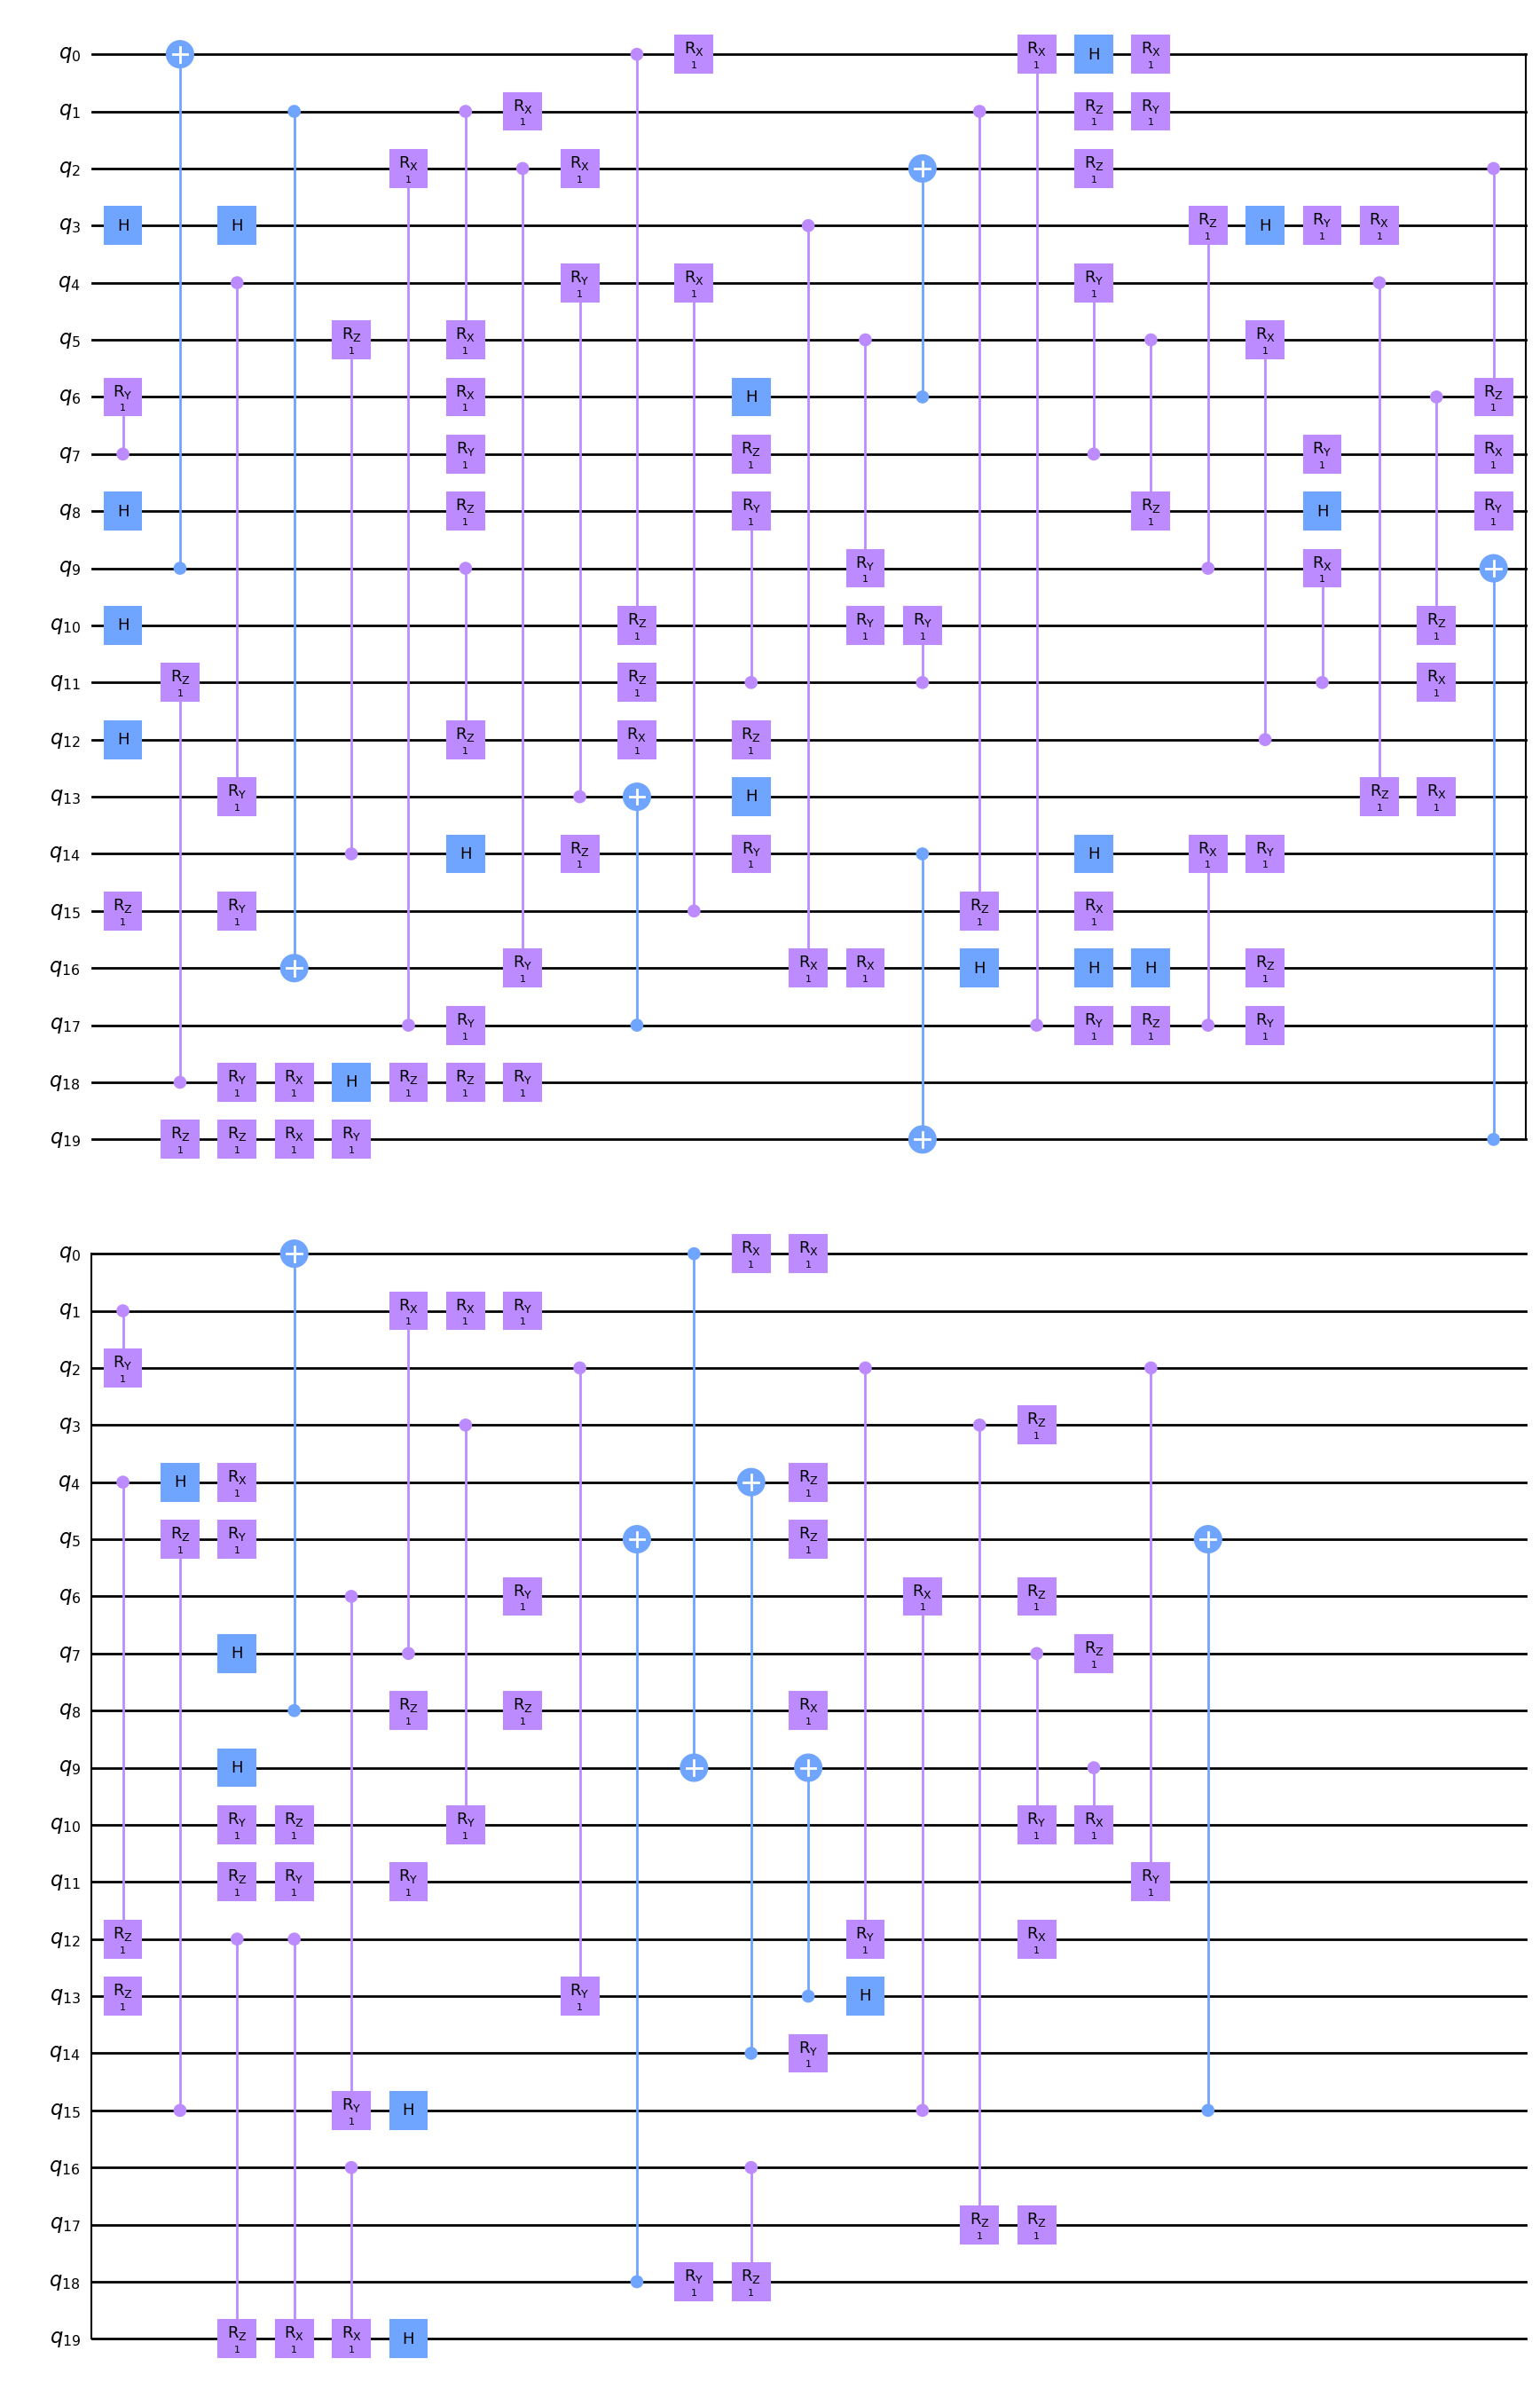

In [12]:
import qiskit.quantum_info as qi
import qimax.constant
from qoop.core.random_circuit import generate_with_pool
from qoop.core.gradient import grad_loss
%load_ext autoreload
%autoreload 2
num_qubits = 20
qc = generate_with_pool(num_qubits, 10)
qc = qc.assign_parameters([1] * qc.num_parameters)
qc.draw('mpl')
# grad_loss1 = grad_loss(qc, [1] * qc.num_parameters)
# print(grad_loss1)

In [47]:
qi.Statevector.from_instruction(qc).data

array([-3.57618320e-04-3.36729584e-05j, -9.46629890e-05-2.24740299e-04j,
       -1.44052202e-03-1.47829753e-03j, ...,
        9.56679909e-06-5.68084490e-06j, -1.25411428e-06+2.69985865e-06j,
        2.33546424e-06+7.16862661e-06j])

In [48]:
qi.Statevector.from_instruction(qc_basis).data

array([-3.57618320e-04-3.36729584e-05j, -9.46629890e-05-2.24740299e-04j,
       -1.44052202e-03-1.47829753e-03j, ...,
        9.56679909e-06-5.68084490e-06j, -1.25411428e-06+2.69985865e-06j,
        2.33546424e-06+7.16862661e-06j])

In [50]:
qc.count_ops()

OrderedDict([('ry', 23),
             ('crx', 21),
             ('h', 21),
             ('rz', 17),
             ('cx', 17),
             ('crz', 13),
             ('rx', 13),
             ('cry', 12)])

In [49]:
qc_basis.count_ops()

OrderedDict([('crx', 21),
             ('ry', 19),
             ('rz', 18),
             ('cx', 17),
             ('crz', 13),
             ('cry', 12),
             ('rx', 11),
             ('h', 11)])

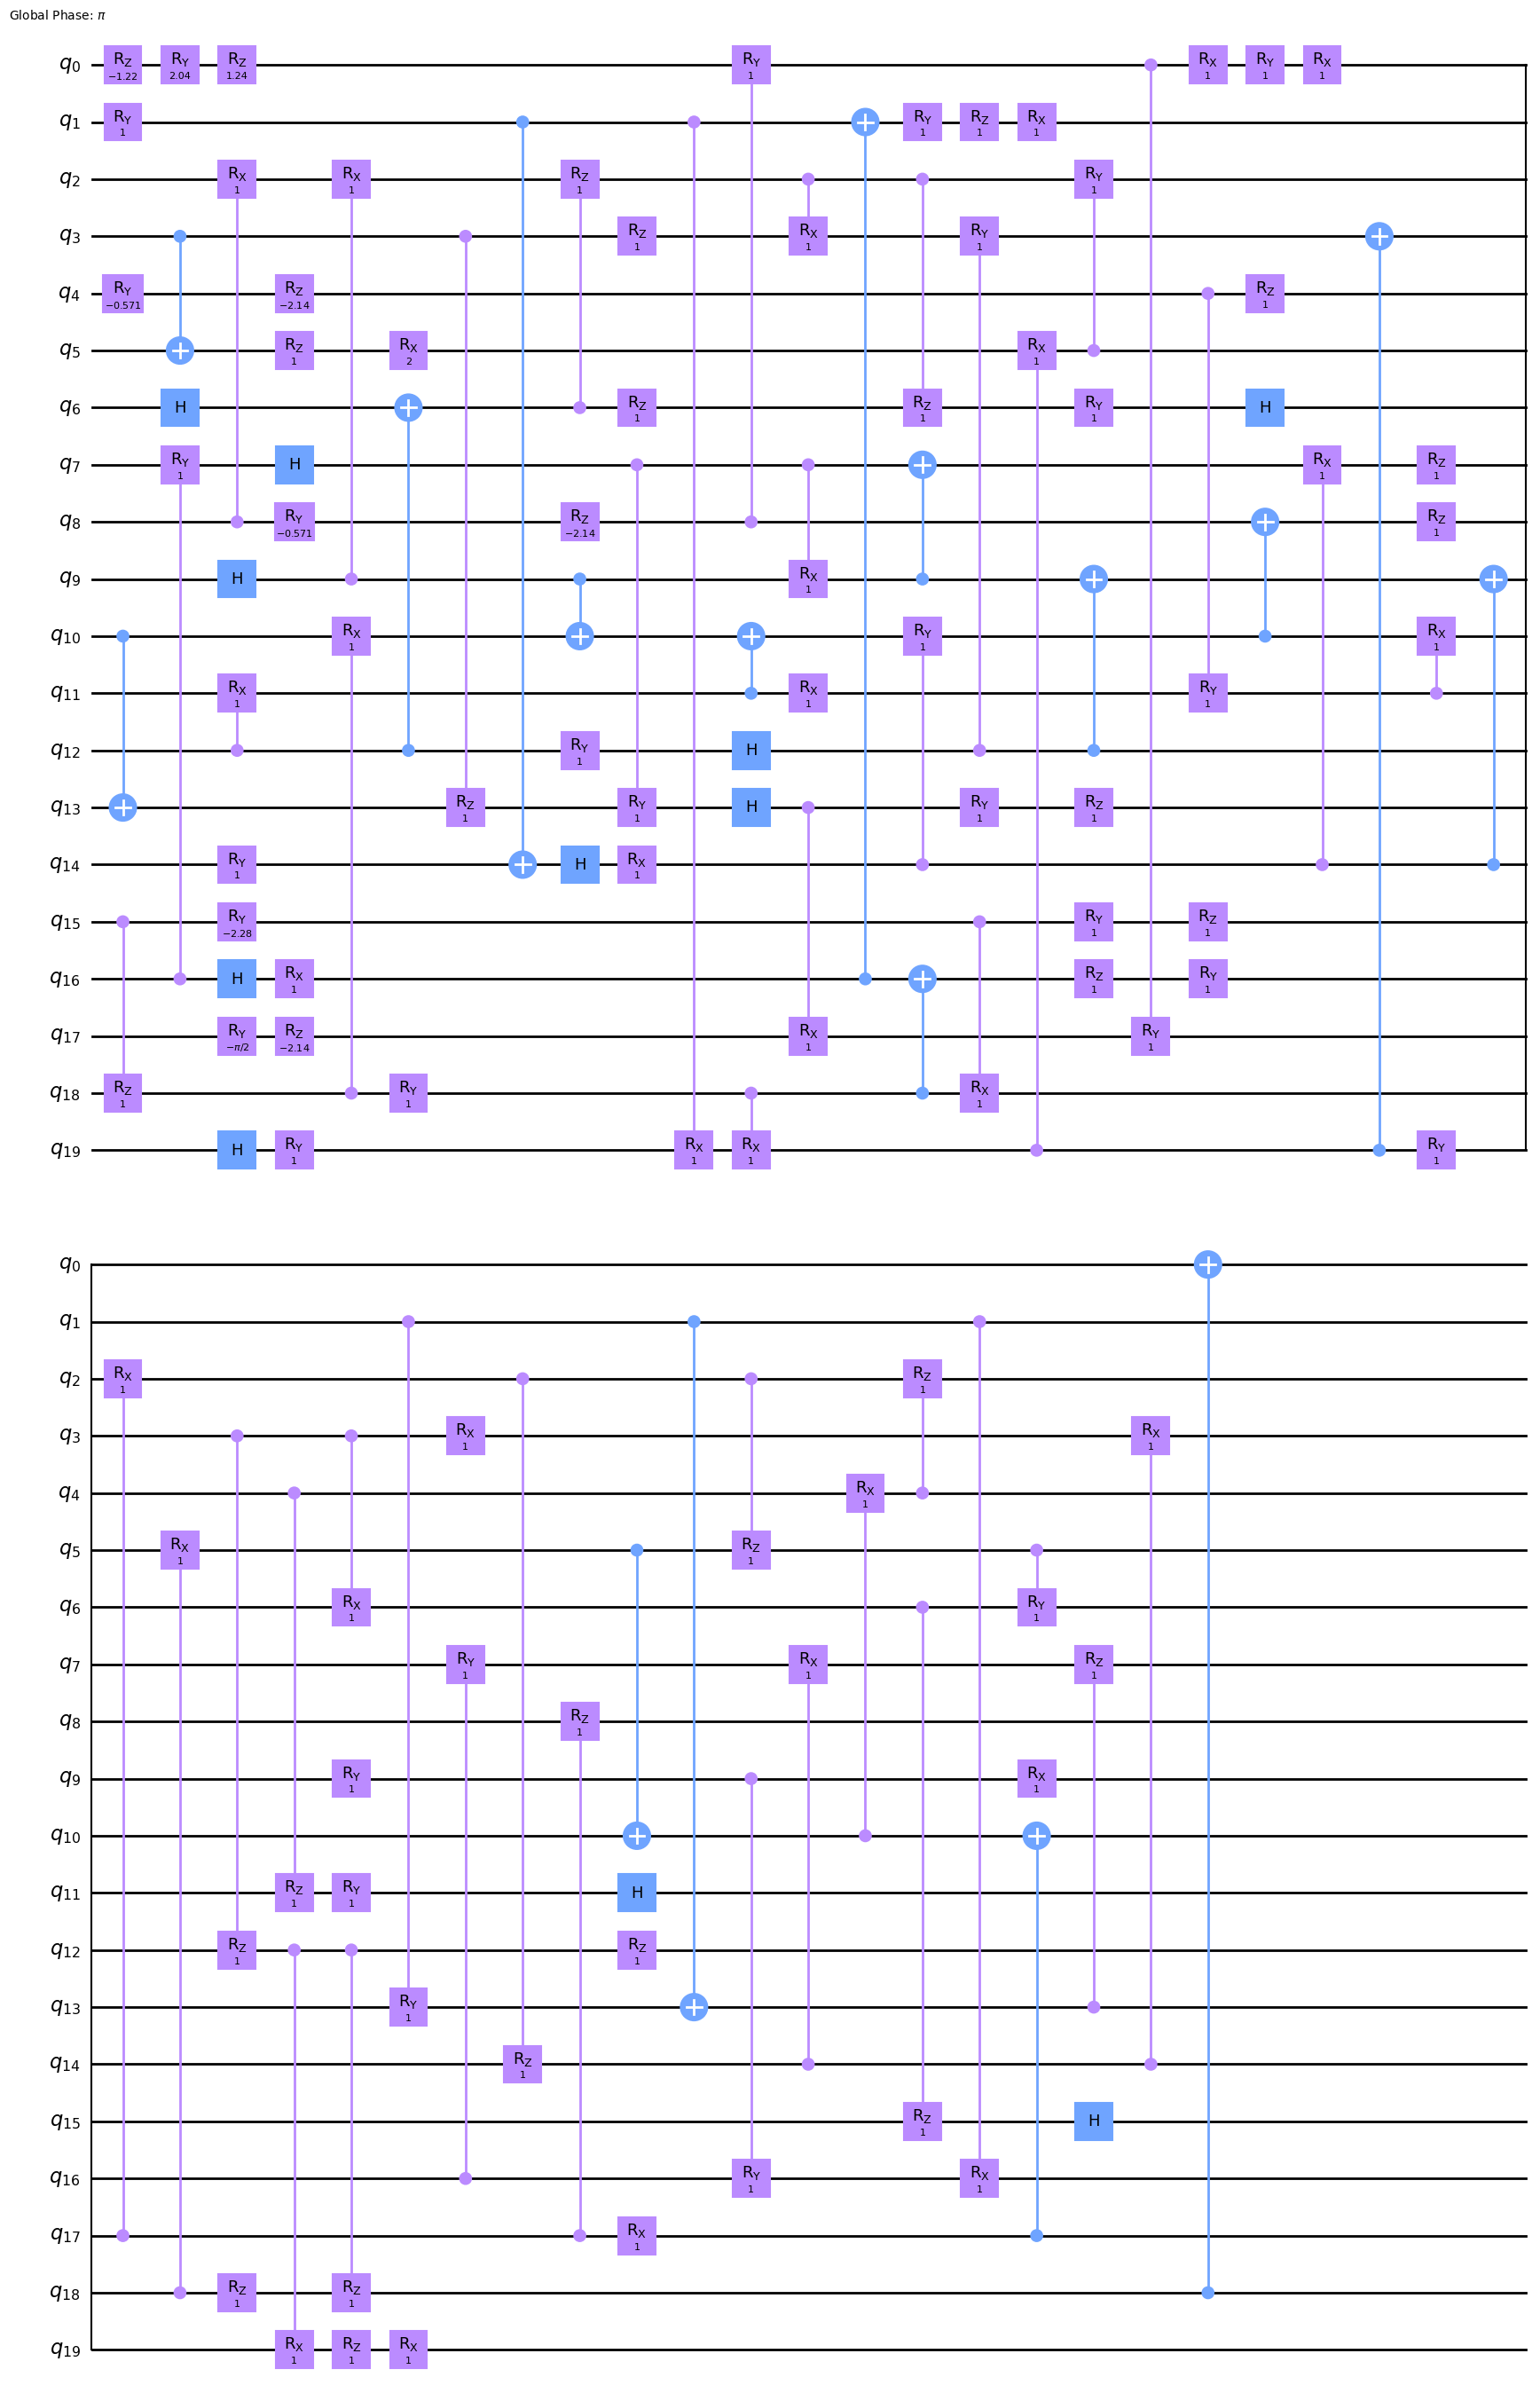

In [46]:
from qiskit.providers.basicaer import QasmSimulatorPy
backend = QasmSimulatorPy()
qc_basis = qiskit.transpile(qc, backend, optimization_level = 1,
    basis_gates=['h', 'cx',
                'rx','ry','rz',
                'crx','cry','crz'])
qc_basis.draw('mpl')

In [13]:
state = qi.Statevector.from_instruction(qc)
state.data

array([ 0.04937702-0.01275364j, -0.01264229+0.01608522j,
       -0.0015097 +0.00921762j, ...,  0.00619189-0.00485945j,
        0.01566362-0.01938955j,  0.00757447+0.03837875j])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


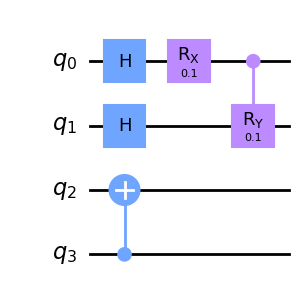

In [68]:
num_qubits = 4
# qc = generate_with_pool(num_qubits, 10)
# qc = qc.assign_parameters([1] * qc.num_parameters)


In [123]:
import qimax.constant
import qimax.converter
import qimax.splitter
import qimax.circuit

def psr(qc):
    qc = qc.assign_parameters([1] * qc.num_parameters)
    num_qubits = qc.num_qubits
    matrices = []
    Us = []
    Usm = [] # [U_{0:m-1}, U_{1:m-1}, ... U_{m-1:m-1}]
    index = 0
    qasm_gates = qimax.converter.qasm_to_qasmgates(qc.qasm())
    qcs = qimax.splitter.qasmgates_to_qcs2(qasm_gates)
    #qcs.reverse() 
    for qasmgates in qcs:
        gates = qimax.converter.qasmgates_to_gates(qasmgates)
        params_form, tensor_form = qimax.converter.gates_to_string(gates, num_qubits)
        u = qimax.circuit.U(params_form, tensor_form, index)
        if u.compare(Us) == False:
            index += 1
            u.to_matrix()
        Us.append(u)
    
    Uresult = []
    Ufront = np.eye(2**num_qubits)
    for i in range(len(Us)):
        Ufront = Us[i].to_matrix() @ Ufront
        Uleft = np.eye(2**num_qubits)
        Uright = np.eye(2**num_qubits)
        for j, u in enumerate(Us):
            if j == i:
                u.plus_params_form(qimax.constant.epsilon)
            Uleft = u.to_matrix() @ Uleft
            if j == i:
                u.plus_params_form(-qimax.constant.epsilon)
            Uright = u.to_matrix() @ Uright
        Uresult.append(Uleft @ qimax.constant.state0(num_qubits))
        Uresult.append(Uright @ qimax.constant.state0(num_qubits))
    Ufront = Ufront @ qimax.constant.state0(num_qubits)
    return Uresult

def qiskit(qc):
    Uresult = []
    num_qubits = qc.num_qubits
    for i in range(len(qc.parameters)):
        Uleft = qi.Statevector.from_instruction(qc.assign_parameters([1]*qc.num_parameters)).data
        Uright = qi.Statevector.from_instruction(qc.assign_parameters([1]*qc.num_parameters)).data
    Uresult.append(Uleft)
    Uresult.append(Uright)
def proposed_psr(qc):
    qc = qc.assign_parameters([1] * qc.num_parameters)
    num_qubits = qc.num_qubits
    matrices = []
    Us = []
    
    index = 0
    qasm_gates = qimax.converter.qasm_to_qasmgates(qc.qasm())
    qcs = qimax.splitter.qasmgates_to_qcs2(qasm_gates)
    #qcs.reverse() 
    # print(qcs)
    for qasmgates in qcs:
        gates = qimax.converter.qasmgates_to_gates(qasmgates)
        params_form, tensor_form = qimax.converter.gates_to_string(gates, num_qubits)
        u = qimax.circuit.U(params_form, tensor_form, index)
        if u.compare(Us) == False:
            index += 1
            u.to_matrix()
        Us.append(u)
    Us.reverse() # Now is [..., U_2, U_1, U_0]
    Usm = [np.eye(2**num_qubits)] 
    Uk = np.eye(2**num_qubits)
    for u in Us[1:]:
        Uk = u.matrix_form @ Uk
        Usm.append(Uk)
    # [I, U_{U_{m-1:m-1}, ..., U_{1:m-1}]
    Usm.reverse() # Now is [U_{1:m-1}, ... U_{m-1:m-1}, I] # ignore U_{0:m-1}, m = 5, [U_{1:4}, U_{2:4}, U_{3:4}, U_{4:4]

    Uresult = []
    Ufront = np.eye(2**num_qubits)
    i = 0
    while i < len(Usm):
        if Us[i].len_params() == 0:
            Uleft = Ufront @ Us[i].to_matrix() @ Usm[i]
            Uright = Ufront
        else:
            Uleft = Ufront @ Us[i].plus_params_form(qimax.constant.epsilon).to_matrix() @ Usm[i]
            Uright = Ufront @ Us[i].plus_params_form(-qimax.constant.epsilon).to_matrix() @ Usm[i]
        Uresult.append(Uleft @ qimax.constant.state0(num_qubits))
        Uresult.append(Uright @ qimax.constant.state0(num_qubits))
        Ufront = Us[i].to_matrix() @ Ufront 
        i += 1
    Ufront = Ufront @ qimax.constant.state0(num_qubits)
    return Uresult



In [144]:
import time

num_qubits = list(range(2, 9))
depths = list(range(2, 9))
time_psr = np.zeros((len(num_qubits), len(depths)))
time_proposed_psr = np.zeros((len(num_qubits), len(depths)))
time_qiskit = np.zeros((len(num_qubits), len(depths)))
for i, num_qubit in enumerate(num_qubits):
    for j, depth in enumerate(depths):
            time_psrs, time_proposed_psrs, time_qiskits = [], [], []
            for k in range(100):
                qc = generate_with_pool(num_qubit, depth)
                start = time.time()
                result1 = psr(qc)
                end = time.time()
                time_psrs.append(end - start)
                start = time.time()
                result1 = proposed_psr(qc)
                end = time.time()
                time_proposed_psrs.append(end - start)
                start = time.time()
                result1 = qiskit(qc)
                end = time.time()
                time_qiskits.append(end - start)
            time_psr[i, j] = np.mean(time_psrs)
            time_proposed_psr[i, j] = np.mean(time_proposed_psrs)
            time_qiskit[i, j] = np.mean(time_qiskits)

In [145]:
np.savetxt("time_psr.csv", time_psr, delimiter=",")
np.savetxt("time_proposed_psr.csv", time_proposed_psr, delimiter=",")
np.savetxt("time_qiskit.csv", time_qiskit, delimiter=",")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


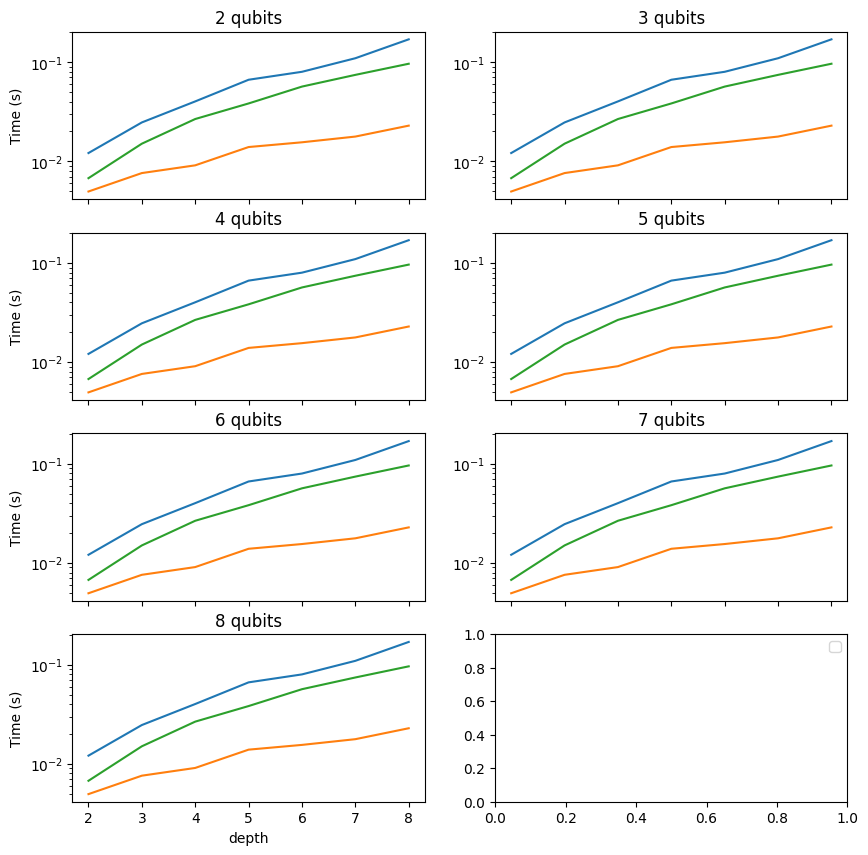

In [155]:
import matplotlib.pyplot as plt

depth = 5
num_qubit = 6
fig, axs = plt.subplots(4, 2, figsize = (10, 10))
j = 0
for i in range(2,9):
    x = j // 2
    y = j % 2
    axs[x,y].plot(range(2, 9), time_psr[num_qubit - 2][:], label = 'Standard PSR')
    axs[x,y].plot(range(2, 9),time_proposed_psr[num_qubit - 2][:], label = 'QIMAX')
    axs[x,y].plot(range(2, 9), time_qiskit[num_qubit - 2][:], label = 'Qiskit')
    
    if y == 0:
        axs[x,y].set_ylabel('Time (s)')
    else:
        axs[x,y].set_yticklabels([])
    axs[x,y].set_xticks(range(2, 9))
    if x == 3:
        axs[x,y].set_xlabel('depth')
    else:
        axs[x,y].set_xticklabels([])
    axs[x,y].set_yscale('log')
    
    axs[x,y].set_title(f'{i} qubits')
    
    j += 1
    
plt.legend()